# Horizontal Integration Demo — DIRAC Annotation for AD (stereo-seq bin100) using DLPFC Visium as Reference

> **Goal.** Annotate Alzheimer’s Disease (AD) **stereo-seq (bin100)** samples by transferring cortical layer labels from a **DLPFC (10x Visium, normal)** reference using **DIRAC**.  
> **Key ideas.**  
> 1) **Horizontal integration**: same tissue context (cortex), different datasets/platforms (stereo-seq vs Visium).  
> 2) **Marker-driven training**: instead of all genes, train on **cell-type marker genes** computed from the reference’s ground truth; users can also provide **their own gene list**.  
> 3) **Generalizable**: works for any cortical region with layers **L1–L6** and **WM**; just replace the AD sample(s) with your own.  
> 4) **Future references**: we will keep collecting additional reference datasets to further improve this workflow.

---

## Table of Contents

1. [Requirements & Data](#requirements--data)  
2. [Pipeline Overview](#pipeline-overview)  
3. [Step-by-step Code (copy/paste)](#step-by-step-code)  
4. [Why marker genes?](#why-markers)  
5. [Using your own gene list](#custom-genes)  
6. [Extending to other cortical regions](#extending)  
7. [Outputs & Saving](#outputs)  
8. [Troubleshooting & Notes](#troubleshooting)

---

<a id="requirements--data"></a>
## 1) Requirements & Data

**Software**
- Python ≥ 3.9
- scanpy, anndata, numpy, pandas, matplotlib
- DIRAC codebase available locally

**Data assumptions**
- **Reference**: DLPFC (10x Visium, normal) AnnData with:
  - `obs["ground_truth"]` (layer labels: L1–L6, WM)
  - (Optional) `obs["batch_name"]` (for multi-sample reference)
  - `obsm["spatial"]` (Visium spots)
- **Targets**: AD stereo-seq **bin100** samples (e.g., Control, Moderate, Severe) with:
  - `obsm["spatial"]` (stereo-seq spots)

**Download link:**  
- https://drive.google.com/drive/folders/1Gvx40AB1HZtJ3yH2V-siuVB4_2Bl1-Iv?usp=drive_link

**Provenance (for citation/reading)**
- **Reference (DLPFC Visium):** “Transcriptome-scale spatial gene expression in the human dorsolateral prefrontal cortex.”  
- **AD targets (stereo-seq bin100):** “Stereo-seq of the prefrontal cortex in aging and Alzheimer’s disease.”
---

---

<a id="pipeline-overview"></a>
## 2) Pipeline Overview

1. **Load reference** DLPFC Visium (normal)  
2. **Compute marker genes** for cortical layers using ground-truth labels in the reference  
3. **Filter reference** to the union of **marker genes**; normalize/log/scale  
4. **Build reference graph** using **multi-batch kNN** (if multiple batches):  
   `source_edge_index = sd.utils.get_multi_edge_index(source_adata_raw.obsm["spatial"], source_adata_raw.obs["batch_name"], n_neighbors=12)`  
5. For **each target AD sample (bin100)**:
   - QC/filter → intersect **common marker genes** → normalize/log/scale  
   - Build **single-sample kNN graph** (n_neighbors=12)  
   - Run **DIRAC annotate** to transfer labels from reference to target  
   - Save predictions and artifacts


---

<a id="step-by-step-code"></a>
## 3) Step-by-step Code (copy/paste)

**3.1 Imports, paths, seed, plotting fonts**

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import anndata
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

sys.path.append("../DIRAC-main")
import sodirac_test as sd
sd.utils.seed_torch(seed=0)

samples = ['Control', 'Moderate', 'Severe']
use_obs_name = 'ground_truth'
data_path = "../DIRAC-main/data/AD"
methods = "DIRAC"
colormaps_clusters  = {'Layer4': '#FFED6F', 'Layer1': '#8DD3C7',  'Layer6': '#B3DE69', 'Layer2': '#BC80BD', 'Layer3': '#BEBADA', 'Layer5': '#FCCDE5', 'WM': '#80B1D3'}
tissue = "PFC-AD-bin100"

**3.2 Load the DLPFC reference; compute markers; preprocess reference**

**What this does**
- `sd.utils.ctg(...)` computes **marker genes from the reference** using its ground-truth labels (e.g., cortical layers **L1–L6, WM**).
- The returned `markers` is a **list of gene symbols** distilled from differential expression across those labels.
- We then **subset** the reference to these markers and run a standard **normalize → log1p → scale** pipeline.

**About `n_genes`**
- `n_genes=50` means: **for each label** in `use_obs_name` (e.g., each cortical layer), select the **top 50 differentially expressed genes** as markers.
- If you have 7 labels (L1–L6 + WM), the **theoretical upper bound** is `7 × 50 = 350` genes; the actual number may be **lower** after removing duplicates across labels.
- Choosing a **smaller** `n_genes` (e.g., 20–30) makes training **faster** and often **more robust** across platforms (Visium ↔ stereo-seq), at the risk of missing subtle layer signals.
- Choosing a **larger** `n_genes` (e.g., 100–200) may capture more biology but can **increase noise**, memory, and runtime; consider this if your data are high quality and layers are hard to separate.
- You can **fully replace** these markers with your **own curated list** if desired (e.g., literature-based cortical markers). In that case, skip `ctg` and assign `markers = your_list`.

In [2]:
source_adata_raw = anndata.read_h5ad(os.path.join(data_path, "DLPFC.h5ad"))

# Differential expression / marker discovery by ground-truth layer labels
markers = sd.utils.ctg(source_adata_raw, use_obs_name, n_genes=50)   
print("Total marker genes:", len(markers))

# Keep only marker genes in the reference; standard normalize/log/scale
source_adata_raw = source_adata_raw[:, markers].copy()
sc.pp.normalize_total(source_adata_raw)
sc.pp.log1p(source_adata_raw)
sc.pp.scale(source_adata_raw)

Total marker genes: 253


---
**3.3 Build the reference spatial graph (horizontal integration needs spatial context)**

In [3]:
# Multi-batch spatial kNN (n_neighbors = 12); requires obs["batch_name"]
# If your reference has a single batch, use get_single_edge_index instead.
source_edge_index = sd.utils.get_multi_edge_index(
        source_adata_raw.obsm["spatial"],
        source_adata_raw.obs["batch_name"],   # ensure this column exists; otherwise adapt
        n_neighbors=12
    )

Average neighbors per node (directed): 12.00 (edges=567948, nodes=47329)


---
**3.4 Run DIRAC annotate for each AD stereo-seq (bin100) target**

Sample Control cells before filter: 31450
Sample Control cells after filter:  29380
Sample Control genes  before filter: 42301
Sample Control genes  after filter:  36750
Common marker genes: 251
Example common genes: ['SCGB1D2', 'MT-ND5', 'PCDH8', 'CAMK2A', 'NCDN']
Average neighbors per node (directed): 12.00 (edges=352560, nodes=29380)
Identified 2 unique domains.


Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!
DIRAC annotate training..: 100%|█| 30


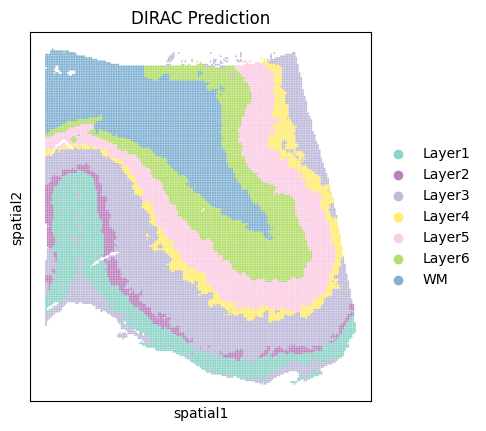

Sample Moderate cells before filter: 34244
Sample Moderate cells after filter:  32892
Sample Moderate genes  before filter: 41463
Sample Moderate genes  after filter:  35740
Common marker genes: 251
Example common genes: ['SCGB1D2', 'MT-ND5', 'PCDH8', 'CAMK2A', 'NCDN']
Average neighbors per node (directed): 12.00 (edges=394704, nodes=32892)
Identified 2 unique domains.


Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!
DIRAC annotate training..: 100%|█| 30


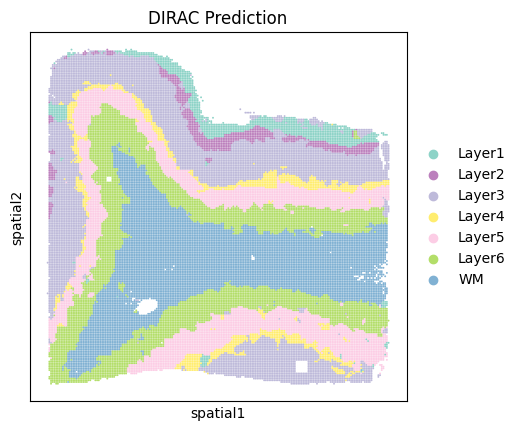

Sample Severe cells before filter: 35513
Sample Severe cells after filter:  23280
Sample Severe genes  before filter: 46008
Sample Severe genes  after filter:  37929
Common marker genes: 252
Example common genes: ['SCGB1D2', 'MT-ND5', 'PCDH8', 'CAMK2A', 'NCDN']
Average neighbors per node (directed): 12.00 (edges=279360, nodes=23280)
Identified 2 unique domains.


Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!
DIRAC annotate training..: 100%|█| 30


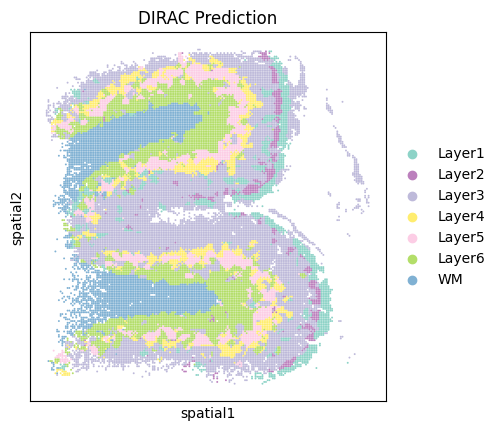

In [4]:
for data_name in samples:
    save_path = os.path.join("./Results", f"Stereo_seq_{tissue}_{methods}_{data_name}")
    os.makedirs(save_path, exist_ok=True)

    # -- Load and quick QC the target
    target_adata = anndata.read_h5ad(os.path.join(data_path, f"{data_name}_bin100.h5ad"))
    target_adata.obsm['spatial'] = target_adata.obsm['spatial'].astype('float32')

    print(f"Sample {data_name} cells before filter: {target_adata.shape[0]}")
    sc.pp.filter_cells(target_adata, min_counts=1100)
    print(f"Sample {data_name} cells after filter:  {target_adata.shape[0]}")
    print(f"Sample {data_name} genes  before filter: {target_adata.shape[1]}")
    sc.pp.filter_genes(target_adata, min_cells=3)
    print(f"Sample {data_name} genes  after filter:  {target_adata.shape[1]}")
    target_adata.raw = target_adata

    # -- Intersect to common marker genes (reference markers ∩ target genes)
    common_genes = list(set(source_adata_raw.var_names) & set(target_adata.var_names) & set(markers))
    print(f"Common marker genes: {len(common_genes)}")
    if len(common_genes) == 0:
        raise ValueError("No common marker genes found. Check gene naming conventions (e.g., case, version).")

    source_adata = source_adata_raw[:, common_genes].copy()
    target_adata = target_adata[:, common_genes].copy()
    print("Example common genes:", common_genes[:5])

    # -- Target preprocess (match reference pipeline)
    sc.pp.filter_cells(target_adata, min_counts=3)
    sc.pp.normalize_total(target_adata)
    sc.pp.log1p(target_adata)
    sc.pp.scale(target_adata)

    # -- Target graph (single-sample spatial kNN)
    target_edge_index = sd.utils.get_single_edge_index(target_adata.obsm["spatial"], n_neighbors=12)

    # -- DIRAC annotate: label transfer from reference -> target
    annotate = sd.main.annotate_app(save_path=save_path, use_gpu=True)
    samples_pkg = annotate._get_data(
            source_data = source_adata.X,
            source_label = source_adata.obs[use_obs_name],
            source_edge_index = source_edge_index,
            target_data = target_adata.X,
            target_edge_index = target_edge_index,
            num_parts_source = max(1, source_adata.shape[0] // 200),
            num_parts_target = max(1, target_adata.shape[0] // 200),
        )

    models = annotate._get_model(samples=samples_pkg, opt_GNN="SAGE")
    results = annotate._train_dirac_annotate(samples=samples_pkg, models=models, n_epochs=30)

    # -- Write back embeddings and predictions
    source_adata.obsm[f"{methods}_embed"] = results["source_feat"]
    target_adata.obsm[f"{methods}_embed"] = results["target_feat"]
    target_adata.obs[f"{methods}_pred"] = results["target_pred"]
    target_adata.obs[f"{methods}"] = target_adata.obs[f"{methods}_pred"].map(results["pairs"])

    # -- Spatial plot of predicted layers on the target
    sc.pl.spatial(
            target_adata,
            color=[f"{methods}"],
            title=[f"{methods} Prediction"],
            show=False,
            spot_size=110,
            palette=colormaps_clusters
        )
    plt.savefig(
            os.path.join(save_path, f"Stereo_seq_{tissue}_{methods}_{data_name}.pdf"),
            dpi=300, bbox_inches='tight'
        )
    plt.show()

    # -- Save the processed target (back to raw counts if you need the original X)
    target_adata_raw_like = target_adata.raw.to_adata()
    target_adata_raw_like.write(os.path.join(save_path, f"Stereo_seq_{tissue}_{methods}_{data_name}.h5ad"),compression="gzip")

    # (Optional) Save results dict safely: arrays + metadata separately
    # Arrays: source_feat/target_feat/target_pred; Meta: pairs
    import json
    np.savez_compressed(
            os.path.join(save_path, f"{tissue}_{methods}_{data_name}_arrays.npz"),
            source_feat=results["source_feat"],
            target_feat=results["target_feat"],
            target_pred=results["target_pred"]
    )

---

<a id="why-markers"></a>
## 4) Why marker genes?

- **Signal-to-noise**: Training only on **reference-informed marker genes** focuses learning on layer-discriminative features.  
- **Platform shift**: Stereo-seq and Visium differ in chemistry/resolution; a **marker subset** improves cross-platform robustness.  
- **Speed & memory**: Fewer genes → faster training and lower memory.

> The demo computes markers via:  
> `markers = sd.utils.ctg(source_adata_raw, use_obs_name="ground_truth")`  
> You can optionally **limit to top N** markers per layer (e.g., by effect size or p-value) before subsetting—simply slice the list.


---

<a id="custom-genes"></a>
## 5) Using your own gene list

- Replace `markers` with your curated list (e.g., union of public cortical markers).  
- The rest of the pipeline stays the same: intersect with target genes → normalize/log/scale → annotate.

**Example**

    markers = [ ... your curated gene symbols ... ]
    # then continue with the same steps:
    source_adata_raw = source_adata_raw[:, markers].copy()
    ...

---

<a id="extending"></a>
## 6) Extending to other cortical regions

- This script is **agnostic** to the cortical area as long as the laminar structure is **L1–L6 + WM**.  
- To apply elsewhere, **replace the AD sample** files with your own region’s stereo-seq data and ensure the **reference** still provides reliable laminar ground truth.  
- For non-DLPFC regions, pick a **matching cortical reference** if available, or retrain marker sets from that region’s ground truth.


---

<a id="outputs"></a>
## 7) Outputs & Saving

Per target sample (`Control`, `Moderate`, `Severe`) you get:

- **PDF**: `Stereo_seq_PFC-AD-bin100_DIRAC_<Sample>.pdf` — spatial map colored by predicted layer  
- **H5AD**: `Stereo_seq_PFC-AD-bin100_DIRAC_<Sample>.h5ad` — processed target AnnData (raw-like)  
- **NPZ/JSON**: `<tissue>_DIRAC_<Sample>_arrays.npz` (embeddings + preds) and `<tissue>_DIRAC_<Sample>_meta.json` (label map)

**Columns in AnnData**
- `obs["DIRAC"]`: predicted cortical layer label per spot  
- `obsm["DIRAC_embed"]`: DIRAC embedding per spot (for neighbors/UMAP downstream)


---

<a id="troubleshooting"></a>
## 8) Troubleshooting & Notes

- **Undefined `batch_name`** in reference: if your reference has no batches, use:
  - `sd.utils.get_single_edge_index(source_adata_raw.obsm["spatial"], n_neighbors=12)`  
- **No common marker genes**: check gene symbol normalization (upper/lower case), Ensembl IDs vs symbols, species builds.  
- **Memory**: if OOM, try `annotate_app(..., use_gpu=True)` with subgraphs:
  - `_get_data(..., num_parts_source=max(1, n_source//200), num_parts_target=max(1, n_target//200))`  
- **Saving `results`**: avoid `np.savez(..., **results)` directly because `results["pairs"]` is a dict; use **NPZ + JSON** as shown.  
- **Colormap**: update `colormaps_clusters` if your label set differs.  
- **Versioning**: pin versions for Scanpy/Anndata/PyTorch to enhance reproducibility.


---

**Next steps.** As we gather more **reference** datasets (beyond DLPFC Visium), we will update marker sets and provide turn-key references for additional cortical regions to make cross-platform annotation even more robust.